In [ ]:
import random
import os
import sys
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import torch, cv2, random
import torchvision
from torch import nn
import albumentations as A
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip "/content/drive/MyDrive/Chess Dataset.zip"

## **Dataset Downloader**

**Augmentation**

In [ ]:
alb_transforms = A.Compose(
    [
        A.HorizontalFlip(),
        A.Rotate(limit=40, p=0.7),
        # A.IAAPerspective(scale=(0.1, 0.1), p=0.7),
        # A.IAASuperpixels(p_replace=0.3, p=0.7),
        # A.IAAAdditiveGaussianNoise(scale=(0.1 * 255, 0.2 * 255), p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.6, p=0.7),
    ]
)

**DatasetLoader**

In [ ]:
class DatasetLoader(Dataset):
    def __init__(self, dataset, class_dict, split, train = True, alb_transforms=None):
      if train:
        data = dataset[:split_length]
      else:
        data = dataset[split_length:]
      
      self.transform = False
      data_transforms = transforms.Compose([
          transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])
      
      if alb_transforms is not None:
        self.transform = True
        data_alb = []
        data_image = []
        labels = []
        for image_loc in tqdm(data):
          image = cv2.imread(image_loc)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = cv2.resize(image, (384,384))
          # transforming and normalizing image
          image_alb = alb_transforms(image=image)["image"]
          # image = image.astype(np.float16)
          # image_alb = image_alb.astype(np.float16)
          image = torch.from_numpy(image)
          image = image.float()
          image_alb = torch.from_numpy(image_alb)
          image_alb = image_alb.float()

          # image channel correction
          if len(image.shape) < 3:
              image = image.unsqueeze(0)
              image_alb = image_alb.unsqueeze(0)
          else:
            image = image.movedim(2,0)
            image_alb = image_alb.movedim(2,0)
          image = data_transforms(image)
          image_alb = data_transforms(image_alb)
          data_image.append(image)
          data_alb.append(image_alb)
          l = image_loc.split("/")[1]
          l = torch.tensor(class_dict[l])
          labels.append(l)
        
        self.data_alb = torch.stack(data_alb)
        self.data = torch.stack(data_image)
        self.label = torch.stack(labels)
      
      else:
        data_image = []
        for image_loc in tqdm(data):
          image = cv2.imread(image_loc)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = cv2.resize(image, (384,384))
          # image = image.astype(np.float16)
          image = torch.from_numpy(image)
          image = image.float()
          # image channel correction
          if len(image.shape) < 3:
            image = image.unsqueeze(0)
          else:
            image = image.movedim(2,0)
          image = data_transforms(image)
          data_image.append(image)
          l = image_loc.split("/")[1]
          l = torch.tensor(class_dict[l])
          labels.append(l.float())
        self.data = torch.stack(data_image)
        self.label = torch.stack(labels)


    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = torch.from_numpy(np.array(self.label[idx], dtype = np.float16))

        if self.transform:
          image_alb = self.data_alb[idx]
          return (image, image_alb, label)
        else:
          return (image, label)

In [ ]:
folders = os.listdir("Chess Dataset/")
dataset = []
for folder in folders:
  files = os.listdir("Chess Dataset/{}/".format(folder))
  for file in files:
    dataset.append("Chess Dataset/{}/{}".format(folder, file))

len(dataset)
random.shuffle(dataset)

In [ ]:
class_dict = {}
for i in range(len(folders)):
  class_dict[folders[i]] = i
class_dict

{'King': 0, 'Rook': 1, 'Bishop': 2, 'Knight': 3, 'Pawn': 4, 'Queen': 5}

In [ ]:
split_length = int(0.95*len(dataset))
print("Train dataset: ", split_length)
print("Test dataset: ", len(dataset)-split_length)
# training data
print("Training Dataset --->")
trainDatasetLoader = DatasetLoader(dataset, class_dict, split_length, train = True,
                                   alb_transforms=alb_transforms)
dataloader_train = DataLoader(trainDatasetLoader, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
# validation data
print("Validation Dataset --->")
valDatasetLoader = DatasetLoader(dataset, class_dict, split_length, train = False,
                                   alb_transforms=alb_transforms)
dataloader_val = DataLoader(valDatasetLoader, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)

Train dataset:  527
Test dataset:  28
Training Dataset --->


  0%|          | 0/527 [00:00<?, ?it/s]

Validation Dataset --->


  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
val = next(iter(dataloader_val))
print(val[0].shape)
print(val[1].shape)
print(val[2].shape)
del val

torch.Size([4, 3, 384, 384])
torch.Size([4, 3, 384, 384])
torch.Size([4])


# Transformer Model

In [ ]:
# Patches Class
class PatchEmbed(nn.Module):
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super(PatchEmbed, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, 
                              kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        # x: (n_samples, in_chans, img_size, img_size)
        x = self.proj(x)
        # x: (n_samples, embed_dim, n_patches**0.5, n_patches**0.5)
        x = x.flatten(2)
        # x: (n_samples, embed_dim, n_patches)
        x = x.transpose(1,2)
        # x: (n_samples, n_patches, embed_dim)
        return x


# Attention Class
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super(Attention, self).__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        # x: (n_samples, n_patches+1, dim)
        n_samples, n_tokens, dim = x.shape
        if dim != self.dim:
            raise ValueError
        
        qkv = self.qkv(x)
        # x: (n_samples, n_patches+1, 3*dim)
        qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim)
        # x: (n_samples, n_patches+1, 3, n_heads, head_dim)
        qkv = qkv.permute(2,0,3,1,4)
        # x: (3, n_samples, n_heads, n_patches+1, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2,-1) 
        # x: (n_samples, n_heads, head_dim, n_patches+1)
        dp = (q @ k_t) * self.scale
        # x: (n_samples, n_heads, n_patches+1, n_patches+1)
        attn = dp.softmax(dim = -1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v
        # x: (n_samples, n_heads, n_patches+1, head_dim)
        weighted_avg = weighted_avg.transpose(1,2)
        # x: (n_samples, n_patches+1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)
        # x: (n_samples, n_patches+1, dims)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        # x: (n_samples, n_patches+1, dims)
        return x


# MLP Class
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        # x: (n_samples, n_patches+1, in_features)
        x = self.fc1(x)
        # x: (n_samples, n_patches+1, hidden_features)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        # x: (n_samples, n_patches+1, out_features)
        x = self.drop(x)
        # x: (n_samples, n_patches+1, out_features)
        return x


# Transformer block
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, 
                 qkv_bias=True, p=0., attn_p=0.):
        super(Block, self).__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads=n_heads, qkv_bias=qkv_bias,
                              attn_p=attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features,
                       out_features=dim)
    
    def forward(self, x):
        # x: (n_samples, n_patches+1, dim)
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


# Transformer block
class VisionTransformer(nn.Module):
    def __init__(self, img_size=384, patch_size=16, in_chans=3, 
                 n_classes=10, embed_dim=768, depth=12, n_heads=12,
                 mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbed(img_size=img_size,
                                      patch_size=patch_size,
                                      in_chans=in_chans, embed_dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1,1+self.patch_embed.n_patches, embed_dim)
        )
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList([
            Block(dim = embed_dim, n_heads=n_heads, mlp_ratio=mlp_ratio,
                  qkv_bias=qkv_bias, p=p, attn_p=attn_p) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim, eps = 1e-6)
        # self.head = nn.Linear(embed_dim, n_classes)
    
    def forward(self, x):
        n_samples = x.shape[0]
        x=self.patch_embed(x)
        cls_token = self.cls_token.expand(n_samples, -1, -1)
        # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)
        # (n_samples, n_patches+1, embed_dim)
        x = x + self.pos_embed
        # (n_samples, n_patches+1, embed_dim)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)
        # (n_samples, n_patches+1, embed_dim)
        x = self.norm(x)
        cls_token_final = x[:,0]
        # x = self.head(cls_token_final)
        # return x
        return cls_token_final

In [ ]:
class VTClusterisator(nn.Module):
    def __init__(self):
        super(VTClusterisator, self).__init__()
        final_features = 768
        self.vt = VisionTransformer()
        self.cluster_head = nn.Linear(final_features, 6)
        self.overcluster_head = nn.Linear(final_features, 20)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, overclustering=False):
        x = self.vt(x)
        if overclustering:
            x = self.overcluster_head(x)
        else:
            x = self.cluster_head(x)
        return self.softmax(x)

In [ ]:
# weight initializer
def weight_init(model):
    if isinstance(model, nn.Conv2d):
        nn.init.xavier_normal_(model.weight, gain=nn.init.calculate_gain("relu"))
        if model.bias is not None:
            nn.init.zeros_(model.bias)

    elif isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        if model.bias is not None:
            nn.init.zeros_(model.bias)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)
model = VTClusterisator()
model.to(device)
print("The model is transfered to", device)
model.apply(weight_init)
print("The weights are Initialised.")

Using cuda
The model is transfered to cuda
The weights are Initialised.


In [ ]:
def IID_loss(x_out, x_tf_out, lamb=1.0, EPS=sys.float_info.epsilon):
    _, num_classes = x_out.size()
    # shape: [1024,10,1] * [1024,1,10] => [1024,10,10]
    p_i_j = x_out.unsqueeze(2) * x_tf_out.unsqueeze(1)
    # shape: [10,10]
    p_i_j = p_i_j.sum(dim=0)
    p_i_j = (p_i_j + p_i_j.t()) / 2.0
    p_i_j = p_i_j / p_i_j.sum() # Normalization
    
    p_i = p_i_j.sum(dim=1).view(num_classes, 1).expand(num_classes, num_classes).clone()
    p_j = p_i_j.sum(dim=0).view(1, num_classes).expand(num_classes, num_classes).clone()
    # avoid NaN losses. Effect will get cancelled out by p_i_j tiny anyway
    p_i_j[(p_i_j < EPS).data] = EPS
    p_j[(p_j < EPS).data] = EPS
    p_i[(p_i < EPS).data] = EPS

    loss = -p_i_j * (torch.log(p_i_j) - lamb * torch.log(p_j) - lamb * torch.log(p_i))
    return loss.sum()

In [ ]:
inp = torch.rand(1,3,384,384)
aug = torch.rand(1,3,384,384)

In [ ]:
input_batch = inp.to(device)
print("Model output shape in clustering mode:", model(inp).shape)
print("Model output shape in overclustering mode:", model(inp, overclustering=True).shape)

**Loss**

In [ ]:
lamb = 1.0
outputs = model(input_batch, overclustering = False)
outputs_tf = model(aug, overclustering = False)
loss = IID_loss(outputs, outputs_tf, lamb=lamb)
print("Loss:", loss.data.cpu().numpy())

In [ ]:
del inp, aug

**Evaluation Function**

In [ ]:
def evaluate(model, dataloader, overclustering=False, lamb=1.0, 
             device=torch.device("cpu")):
    losses = []
    if overclustering:
      print("Overhead Clustering Evaluation --->")
    else:
      print("Clustering Evaluation --->")
    model.eval()
    for batch in tqdm(dataloader):
        inputs = batch[0]
        inputs_tf = batch[1]
        with torch.no_grad():
            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)
            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
        loss = IID_loss(outputs, outputs_tf, lamb=lamb)
        losses.append(loss.data.cpu().numpy())
    return np.mean(losses)

**Auxilary Function**

In [ ]:
def choose_clustering_regime(epoch, overcluster_period, overcluster_ratio):
    if (
        overcluster_period is not None
        and epoch % overcluster_period < overcluster_period * overcluster_ratio
    ):
        return True
    else:
        return False

def print_while_trainig(epochs_list, loss_history, loss_history_overclustering):
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_figwidth(12)

    ax1.plot(epochs_list, loss_history, label="train_loss")
    ax1.legend()
    ax1.grid()

    ax2.plot(
        epochs_list, loss_history_overclustering, label="train_loss_overclustering"
    )
    ax2.legend()
    ax2.grid()
    plt.show()

In [ ]:
def model_test(model, dataloader,device=torch.device("cpu")):
    model.eval()
    original_labels = []
    cluster_labels = []
    for batch in dataloader:
        images = batch[0].to(device)
        labels = batch[2].to(device)
        outputs = model(images, False)
        original_labels += labels.tolist()
        cluster_labels += torch.argmax(outputs, dim=1).tolist()
    return original_labels, cluster_labels

def visualise_clusetering_results(original_labels, cluster_labels, figwidth=20):
    original_labels = np.array(original_labels)
    cluster_labels = np.array(cluster_labels)
    class_ids = np.unique(original_labels)
    fig, axes = plt.subplots(2, 3, constrained_layout=True)
    fig.set_figwidth(figwidth)

    for idx, ax in enumerate(axes.reshape(-1)):
        labels_distribution = original_labels[cluster_labels == idx]
        counts = np.array([np.sum(labels_distribution == i) for i in range(6)])
        ax.bar(list(range(6)), counts)
        ax.set_xticks(np.arange(6))
        ax.set_xlim([0, 5])
        ax.set_title("Original label: %i" % idx)

**Training Code**

In [ ]:
def train(modeldataset, dataloader, dataloader_val, optimizer, epochs=100,
    device=torch.device("cpu"), eval_every=5, lamb=1.0,
    overcluster_period=20, overcluster_ratio=0.5, model_name = "vt"):
    
    epochs_list = []
    loss_history = []
    loss_history_overclustering = []
    best_cluster_loss = 0
    best_overcluster_loss = 0
    
    for epoch in range(epochs):
        print("Epoch {}/{}:".format(epoch+1, epochs))
        model.train()
        overclustering = choose_clustering_regime(
            epoch, overcluster_period, overcluster_ratio
        )
        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            inputs = batch[0]
            inputs_tf = batch[1]
            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)
            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
            loss = IID_loss(outputs, outputs_tf, lamb=lamb)
            loss.backward()
            optimizer.step()
        # evaluation
        if (epoch + 1) % eval_every == 0:
            loss_eval = evaluate(
                model, dataloader_val, overclustering=False, lamb=lamb, device=device
            )
            loss_eval_overclustering = evaluate(
                model, dataloader_val, overclustering=True, lamb=lamb, device=device
            )

            loss_history.append(loss_eval)
            print(loss_history)
            loss_history_overclustering.append(loss_eval_overclustering)
            print(loss_history_overclustering)
            epochs_list.append(epoch)
            if loss_eval < best_cluster_loss:
                best_cluster_loss = loss_eval
                torch.save(model.state_dict(), "/content/{}_cifar10.pth".format(model_name))
            print_while_trainig(epochs_list, loss_history, loss_history_overclustering)
    print("Best Clustering Loss Value:", best_cluster_loss)

Epoch 1/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 2/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 3/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 4/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 5/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/7 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/7 [00:00<?, ?it/s]

[-0.59879905]
[-0.71641016]


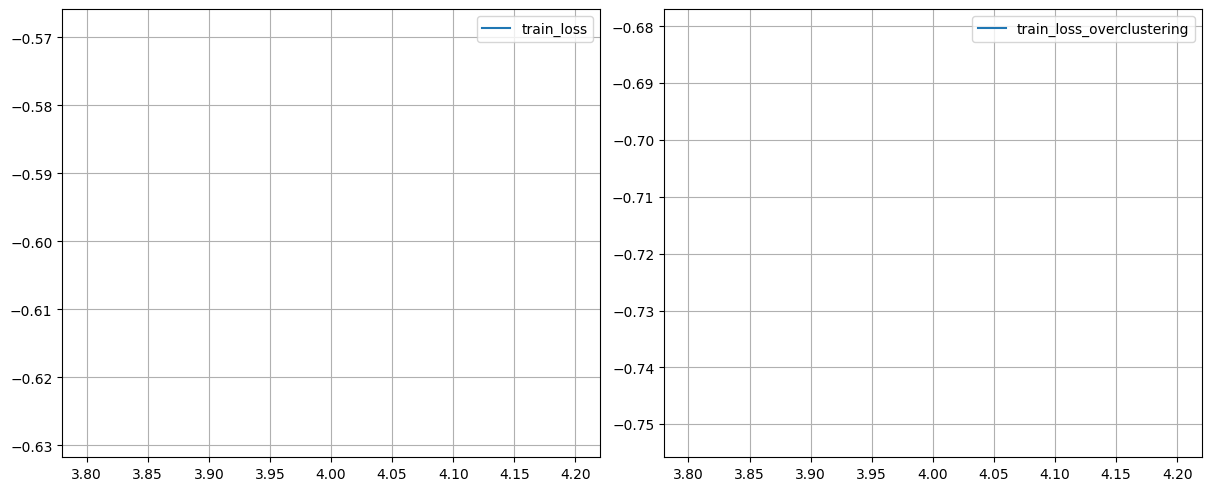

Epoch 6/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 7/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 8/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 9/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 10/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/7 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/7 [00:00<?, ?it/s]

[-0.59879905, -0.60964584]
[-0.71641016, -4.105692e-12]


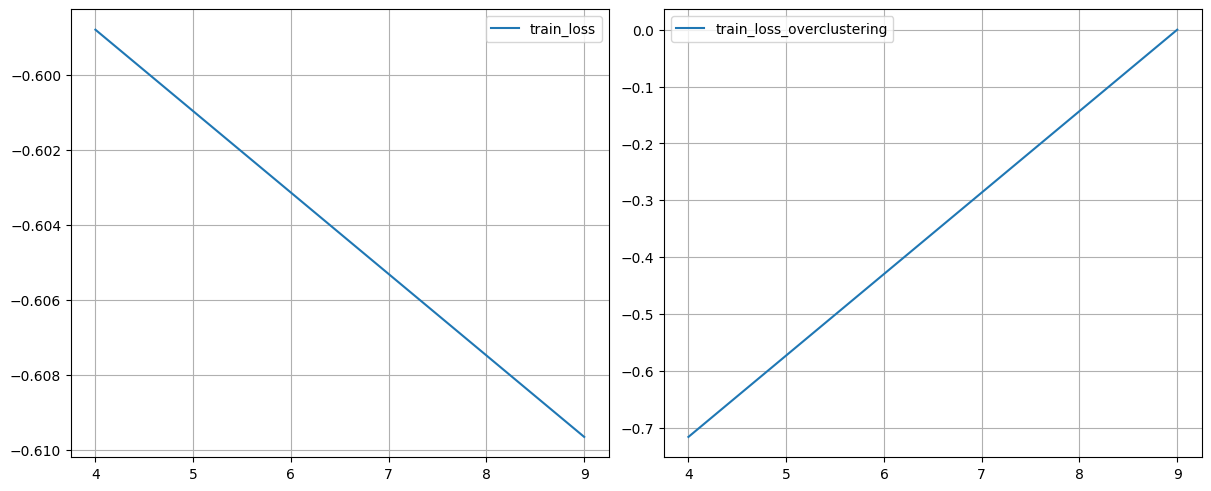

Epoch 11/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 12/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 13/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 14/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 15/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/7 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/7 [00:00<?, ?it/s]

[-0.59879905, -0.60964584, -0.43944713]
[-0.71641016, -4.105692e-12, -4.105692e-12]


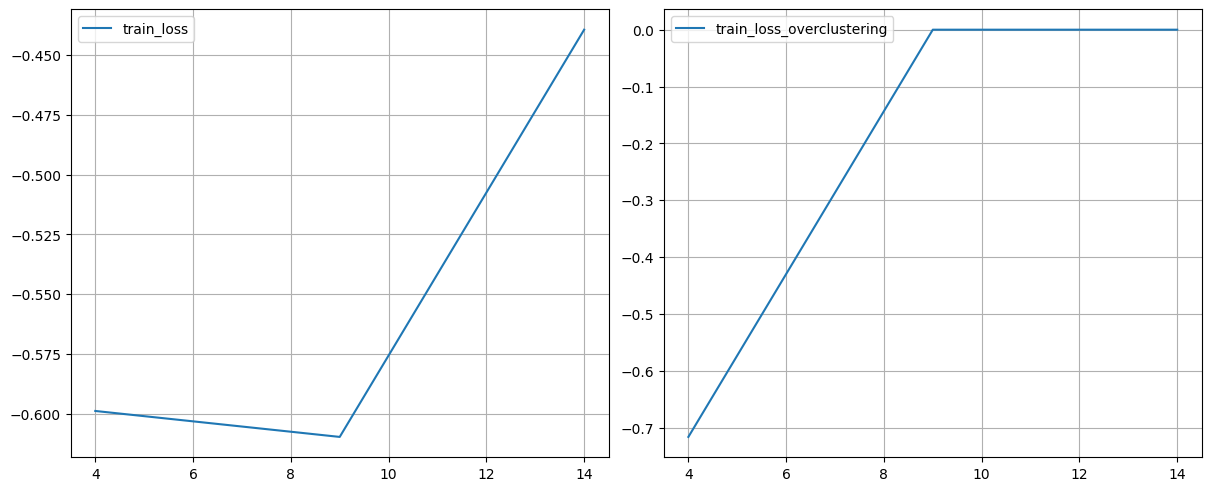

Epoch 16/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 17/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 18/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 19/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 20/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/7 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/7 [00:00<?, ?it/s]

[-0.59879905, -0.60964584, -0.43944713, -0.43943578]
[-0.71641016, -4.105692e-12, -4.105692e-12, -4.105692e-12]


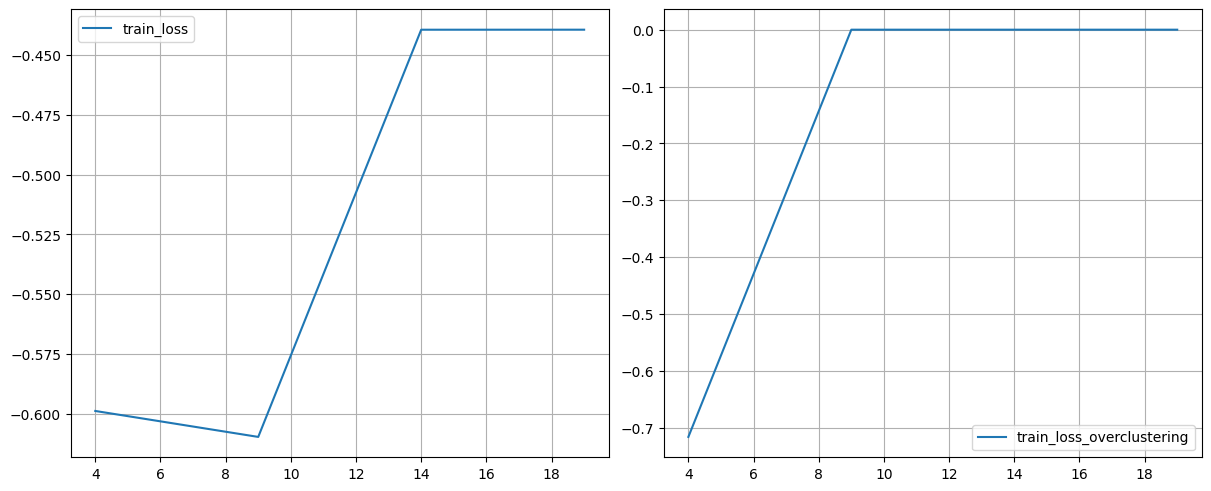

Epoch 21/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 22/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 23/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 24/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 25/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/7 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/7 [00:00<?, ?it/s]

[-0.59879905, -0.60964584, -0.43944713, -0.43943578, -0.43928304]
[-0.71641016, -4.105692e-12, -4.105692e-12, -4.105692e-12, -4.105692e-12]


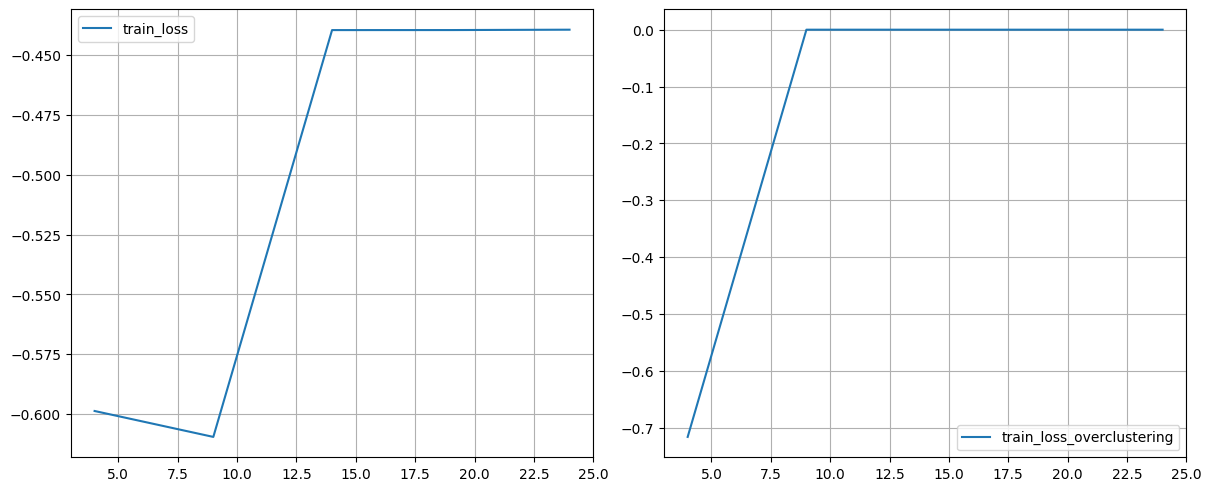

Epoch 26/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 27/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 28/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 29/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 30/30:


  0%|          | 0/132 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/7 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/7 [00:00<?, ?it/s]

[-0.59879905, -0.60964584, -0.43944713, -0.43943578, -0.43928304, -0.43928295]
[-0.71641016, -4.105692e-12, -4.105692e-12, -4.105692e-12, -4.105692e-12, -4.105692e-12]


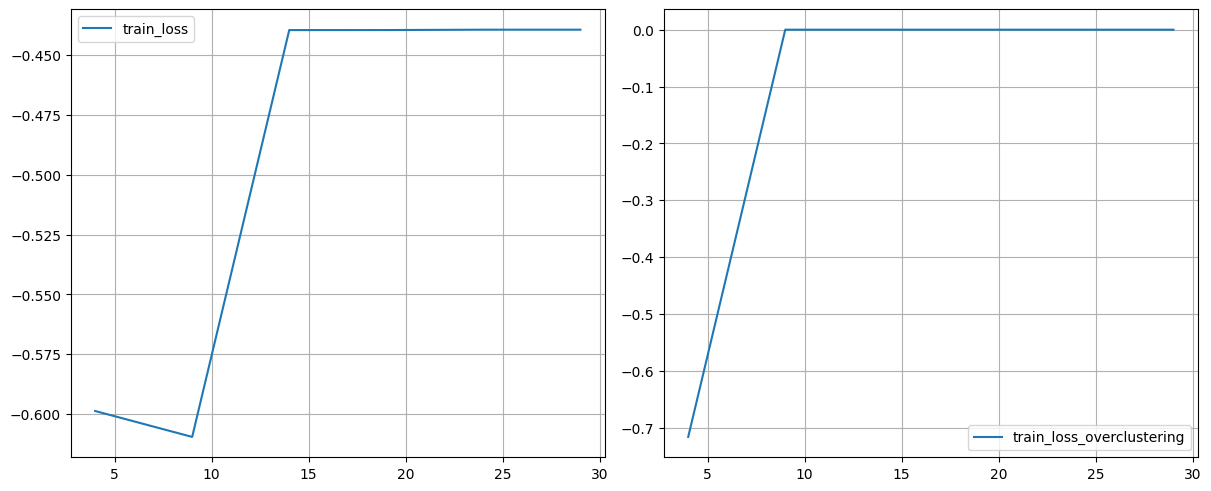

Best Clustering Loss Value: -0.60964584


In [ ]:
# training
optimizer = torch.optim.Adam(
    model.parameters(), lr=4e-3, betas=(0.9, 0.999), eps=1e-6,
    weight_decay=0, amsgrad=False)

train( model, dataloader_train, dataloader_val,
    optimizer, device=device, epochs=30, lamb=1.2,
    overcluster_period=20, overcluster_ratio=0.5)

**Loading best model**

In [ ]:
test_model = VTClusterisator()
test_model.load_state_dict(torch.load("/content/vt_cifar10.pth"))
test_model.to(device)

VTClusterisator(
  (vt): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNorm((768,), eps=1e-06, elementwi

In [ ]:
# data testing
original_labels, cluster_labels = model_test(
    test_model, dataloader_val, device=device
)

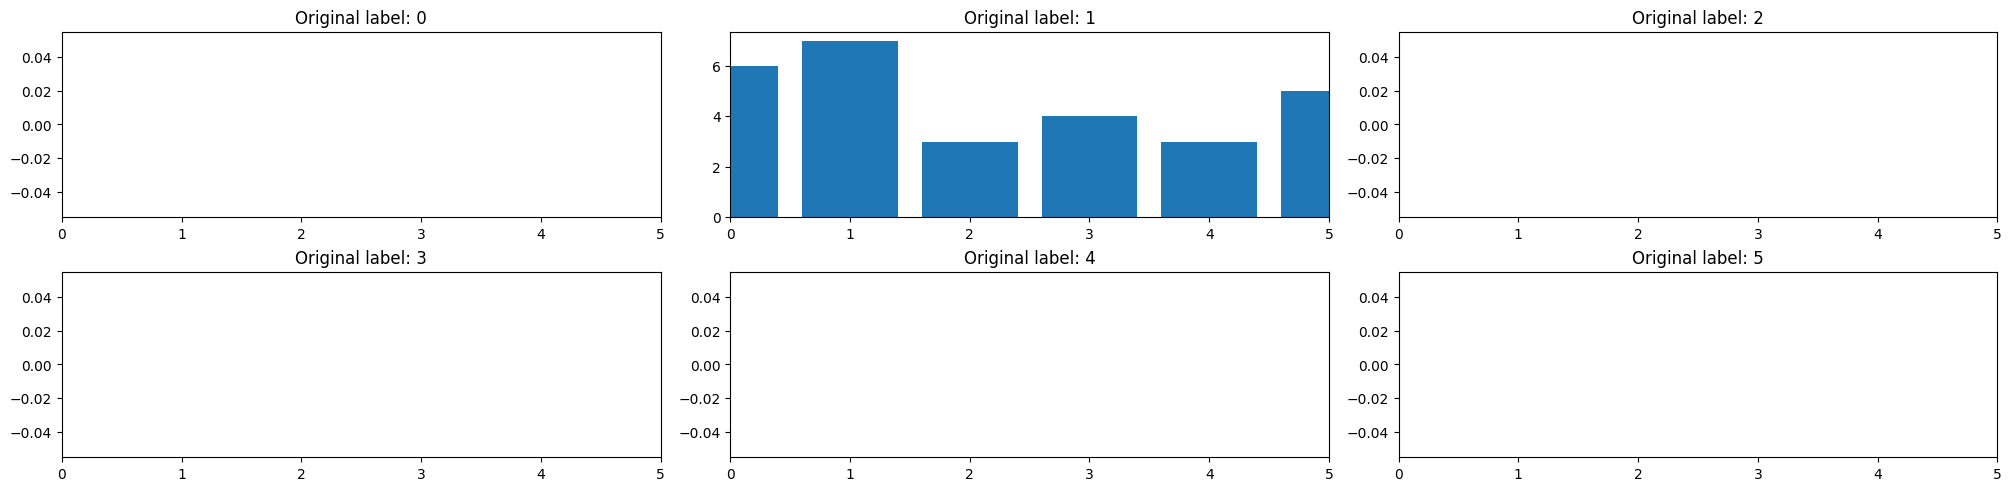

In [ ]:
# visualization
visualise_clusetering_results(original_labels1, cluster_labels)

In [ ]:
adj_score = adjusted_rand_score(cluster_labels, original_labels1)
hom_score = homogeneity_score(cluster_labels, original_labels1)
compl_score = completeness_score(cluster_labels, original_labels1)

print("Adjusted rand score: %.3f " % adj_score)
print("Homogeneity score: %.3f " % adj_score)
print("Completeness score: %.3f" % compl_score)

Adjusted rand score: 0.041
Homogeneity score: 0.041
Completeness score: 0.044


In [ ]:
accuracy_score(original_labels1, cluster_labels)